# Model Training: Hybrid CNN-LSTM
## Stanford TECH 27 Final Project - Notebook 08a

This notebook trains a hybrid CNN-LSTM model for SOC estimation, combining the feature extraction capabilities of CNNs with the temporal modeling strength of LSTMs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers
import warnings
import pickle
from pathlib import Path
import time
import sys
sys.path.append('.')
from data_processing_utils import filter_features, get_realistic_features

warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")
if len(tf.config.list_physical_devices('GPU')) > 0:
    print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")

Libraries imported successfully!
TensorFlow version: 2.20.0
GPU available: False


## Load Sequential Data

Load the CNN sequential datasets from notebook 05 (we'll use the CNN data with 60 timesteps for this hybrid model).

In [2]:
# Load CNN sequential data from notebook 05_final_processing.ipynb
OUTPUT_DIR = Path('processed_data')
cnn_datasets_path = OUTPUT_DIR / 'final_cnn_ml_datasets.pkl'

if cnn_datasets_path.exists():
    print(f"Loading CNN sequential datasets from {cnn_datasets_path}...")
    with open(cnn_datasets_path, 'rb') as f:
        cnn_datasets = pickle.load(f)
    
    # Extract the full datasets
    X_train_full = cnn_datasets['X_train']
    X_val_full = cnn_datasets['X_val']
    X_test_full = cnn_datasets['X_test']
    y_train = cnn_datasets['y_train']
    y_val = cnn_datasets['y_val']
    y_test = cnn_datasets['y_test']
    
    # Get all feature names
    all_feature_names = cnn_datasets.get('feature_names', 
                                         [f'feature_{i}' for i in range(X_train_full.shape[2])])
    
    print(f"✅ Successfully loaded CNN datasets from notebook 5")
    print(f"Full dataset shapes:")
    print(f"   Training:   X={X_train_full.shape}, y={y_train.shape}")
    print(f"   Validation: X={X_val_full.shape}, y={y_val.shape}")
    print(f"   Test:       X={X_test_full.shape}, y={y_test.shape}")
    print(f"\nSequence length: {X_train_full.shape[1]} timesteps")
    print(f"Number of features: {X_train_full.shape[2]}")
    
else:
    print(f"❌ Error: Could not find {cnn_datasets_path}")
    print("Please run notebook 05_final_processing.ipynb first to generate the CNN datasets.")
    raise FileNotFoundError(f"Dataset file not found: {cnn_datasets_path}")

Loading CNN sequential datasets from processed_data/final_cnn_ml_datasets.pkl...
✅ Successfully loaded CNN datasets from notebook 5
Full dataset shapes:
   Training:   X=(65297, 60, 45), y=(65297,)
   Validation: X=(20303, 60, 45), y=(20303,)
   Test:       X=(22669, 60, 45), y=(22669,)

Sequence length: 60 timesteps
Number of features: 45


## Filter Features

Filter the dataset to use only the realistic features available from V, I, T measurements.

In [3]:
# Get the standard list of realistic features from centralized function
features = get_realistic_features()

# Use the centralized filter_features function to filter datasets
filtered_data = filter_features(
    X_train_full, X_val_full, X_test_full,
    all_feature_names, features,
    y_train=y_train, y_val=y_val, y_test=y_test,
    verbose=True
)

# Extract the filtered datasets
X_train = filtered_data['X_train']
X_val = filtered_data['X_val']
X_test = filtered_data['X_test']
available_realistic = filtered_data['available_features']


Feature Selection Summary:
   Total features in dataset: 45
   Features requested: 24
   Features available: 24
   Features excluded: 21

Filtered dataset shapes:
   Training:   X=(65297, 60, 24), y=(65297,)
   Validation: X=(20303, 60, 24), y=(20303,)
   Test:       X=(22669, 60, 24), y=(22669,)

Feature reduction: 45 → 24 features
Sequence length: 60 timesteps

Using 24 features:
  1. voltage
  2. current
  3. temperature
  4. Current_load
  5. Voltage_load
  6. power
  7. abs_current
  8. voltage_current_ratio
  9. energy
 10. voltage_change
 11. current_change
 12. power_change
 13. temperature_change
 14. voltage_rolling_mean_5
 15. voltage_rolling_mean_10
 16. voltage_rolling_std_5
 17. voltage_rolling_std_10
 18. current_rolling_mean_5
 19. current_rolling_mean_10
 20. current_rolling_std_5
 21. current_rolling_std_10
 22. voltage_lag_1
 23. current_lag_1
 24. cumulative_energy


## Model Evaluation Functions

In [4]:
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model performance with multiple metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Convert to percentage for SOC
    rmse_percent = rmse * 100
    mae_percent = mae * 100
    
    print(f"\n{model_name} Performance:")
    print(f"  R² Score: {r2:.6f}")
    print(f"  RMSE: {rmse:.6f} ({rmse_percent:.3f}% SOC)")
    print(f"  MAE: {mae:.6f} ({mae_percent:.3f}% SOC)")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2,
            'rmse_percent': rmse_percent, 'mae_percent': mae_percent}

def plot_predictions(y_true, y_pred, model_name, dataset_name=''):
    """Plot predicted vs actual values."""
    plt.figure(figsize=(8, 6))
    
    # Sample for visualization if too many points
    if len(y_true) > 10000:
        sample_idx = np.random.choice(len(y_true), 10000, replace=False)
        y_true_sample = y_true[sample_idx]
        y_pred_sample = y_pred[sample_idx]
    else:
        y_true_sample = y_true
        y_pred_sample = y_pred
    
    plt.scatter(y_true_sample * 100, y_pred_sample * 100, alpha=0.6, s=1)
    
    # Plot perfect prediction line
    plt.plot([0, 100], [0, 100], 'r--', lw=2, label='Perfect Prediction')
    
    plt.xlabel('Actual SOC (%)')
    plt.ylabel('Predicted SOC (%)')
    plt.title(f'{model_name} - Predicted vs Actual {dataset_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add R² score to plot
    r2 = r2_score(y_true, y_pred)
    rmse_percent = np.sqrt(mean_squared_error(y_true, y_pred)) * 100
    plt.text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse_percent:.2f}%', 
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    """Plot training and validation loss over epochs."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # MAE plot
    if 'mae' in history.history:
        axes[1].plot(history.history['mae'], label='Training MAE')
        axes[1].plot(history.history['val_mae'], label='Validation MAE')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('MAE')
        axes[1].set_title('Training and Validation MAE')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Build Hybrid CNN-LSTM Model

In [5]:
def build_hybrid_cnn_lstm_model(sequence_length, n_features, 
                                cnn_filters=[32, 64], kernel_sizes=[5, 3],
                                lstm_units=[64, 32], 
                                dropout_rate=0.3, l2_reg=0.01):
    """
    Build a hybrid CNN-LSTM model for SOC estimation.
    
    Args:
        sequence_length: Length of input sequences
        n_features: Number of features
        cnn_filters: List of filter sizes for Conv1D layers
        kernel_sizes: List of kernel sizes for Conv1D layers
        lstm_units: List of LSTM unit sizes
        dropout_rate: Dropout rate for regularization
        l2_reg: L2 regularization strength
    """
    from tensorflow.keras import regularizers
    
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(sequence_length, n_features)),
        
        # CNN Feature Extraction Block 1
        layers.Conv1D(cnn_filters[0], kernel_sizes[0], 
                     padding='same', activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(dropout_rate),
        
        # CNN Feature Extraction Block 2
        layers.Conv1D(cnn_filters[1], kernel_sizes[1], 
                     padding='same', activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(dropout_rate),
        
        # LSTM Temporal Modeling Block
        # First LSTM layer
        layers.LSTM(lstm_units[0], 
                   return_sequences=True,
                   dropout=dropout_rate,
                   recurrent_dropout=dropout_rate/2),
        layers.BatchNormalization(),
        
        # Second LSTM layer
        layers.LSTM(lstm_units[1],
                   dropout=dropout_rate,
                   recurrent_dropout=dropout_rate/2),
        layers.BatchNormalization(),
        
        # Dense layers for final prediction
        layers.Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.Dense(16, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')  # Sigmoid for SOC in range [0, 1]
    ])
    
    return model

# Build the model
sequence_length = X_train.shape[1]
n_features = X_train.shape[2]

print("Building Hybrid CNN-LSTM model...")
hybrid_model = build_hybrid_cnn_lstm_model(
    sequence_length=sequence_length,
    n_features=n_features,
    cnn_filters=[32, 64],
    kernel_sizes=[5, 3],
    lstm_units=[64, 32],
    dropout_rate=0.3,
    l2_reg=0.01
)

# Compile the model
hybrid_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

# Display model architecture
print("\nModel Architecture:")
hybrid_model.summary()

# Count parameters
total_params = hybrid_model.count_params()
print(f"\nTotal parameters: {total_params:,}")

Building Hybrid CNN-LSTM model...

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 60, 32)         │         3,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 15, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,889 (226.13 KB)

 Trainable params: 57,505 (224.63 KB)

 Non-trainable params: 384 (1.50 KB)


Total parameters: 57,889


## Train the Model

In [6]:
print("="*60)
print("TRAINING HYBRID CNN-LSTM")
print("="*60)

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = callbacks.ModelCheckpoint(
    OUTPUT_DIR / 'best_hybrid_cnn_lstm_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Training parameters
batch_size = 256
epochs = 100

print(f"\nTraining parameters:")
print(f"   Batch size: {batch_size}")
print(f"   Max epochs: {epochs}")
print(f"   Early stopping patience: 10")
print(f"   Learning rate: 0.0005")
print(f"   Learning rate reduction factor: 0.5")
print(f"   Dropout rate: 0.3")
print(f"   Recurrent dropout: 0.15")
print(f"   L2 regularization: 0.01")
print(f"   CNN filters: [32, 64]")
print(f"   LSTM units: [64, 32]")
print(f"   Architecture: 2 Conv blocks + 2 LSTM layers + 2 Dense layers")

# Train the model
print(f"\nStarting training...")
start_time = time.time()

history = hybrid_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"Best epoch: {np.argmin(history.history['val_loss']) + 1}")
print(f"Best validation loss: {np.min(history.history['val_loss']):.6f}")

TRAINING HYBRID CNN-LSTM

Training parameters:
   Batch size: 256
   Max epochs: 100
   Early stopping patience: 10
   Learning rate: 0.0005
   Learning rate reduction factor: 0.5
   Dropout rate: 0.3
   Recurrent dropout: 0.15
   L2 regularization: 0.01
   CNN filters: [32, 64]
   LSTM units: [64, 32]
   Architecture: 2 Conv blocks + 2 LSTM layers + 2 Dense layers

Starting training...
Epoch 1/100
254/256 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0276 - mae: 0.2800
Epoch 1: val_loss improved from None to 0.30881, saving model to processed_data/best_hybrid_cnn_lstm_model.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7250 - mae: 0.2215 - val_loss: 0.3088 - val_mae: 0.1622 - learning_rate: 5.0000e-04
Epoch 2/100
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2383 - mae: 0.1592
Epoch 2: val_loss improved from 0.30881 to 0.08743, saving model to processed_data/best_hybrid_cnn_lstm_model.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.1806 - mae: 0.1457 - val_lo

## Visualize Training History

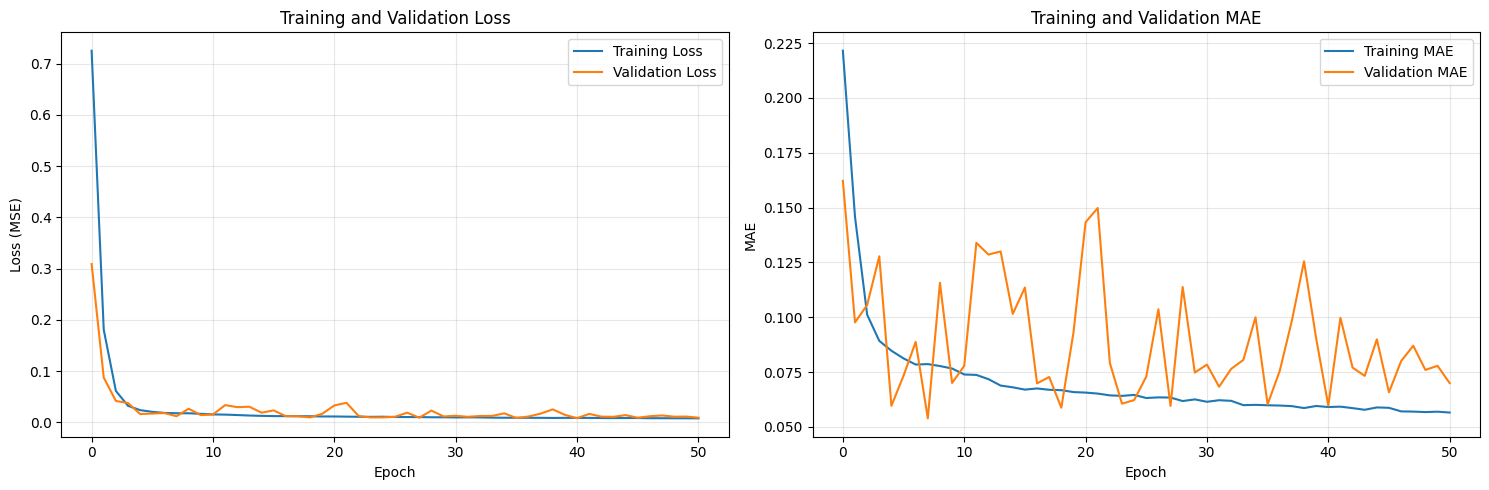


Training Summary:
   Final training loss: 0.007985
   Final validation loss: 0.009252
   Final training MAE: 0.056515
   Final validation MAE: 0.069940
   Total epochs trained: 51


In [7]:
# Plot training history
plot_training_history(history)

# Additional training metrics
print("\nTraining Summary:")
print(f"   Final training loss: {history.history['loss'][-1]:.6f}")
print(f"   Final validation loss: {history.history['val_loss'][-1]:.6f}")
print(f"   Final training MAE: {history.history['mae'][-1]:.6f}")
print(f"   Final validation MAE: {history.history['val_mae'][-1]:.6f}")
print(f"   Total epochs trained: {len(history.history['loss'])}")

## Evaluate Model Performance

In [8]:
# Make predictions
print("Making predictions...")
hybrid_train_pred = hybrid_model.predict(X_train, batch_size=batch_size, verbose=0).flatten()
hybrid_val_pred = hybrid_model.predict(X_val, batch_size=batch_size, verbose=0).flatten()
hybrid_test_pred = hybrid_model.predict(X_test, batch_size=batch_size, verbose=0).flatten()

# Evaluate performance
hybrid_train_metrics = evaluate_model(y_train, hybrid_train_pred, "Hybrid CNN-LSTM (Training)")
hybrid_val_metrics = evaluate_model(y_val, hybrid_val_pred, "Hybrid CNN-LSTM (Validation)")
hybrid_test_metrics = evaluate_model(y_test, hybrid_test_pred, "Hybrid CNN-LSTM (Test)")

print("\nHybrid CNN-LSTM evaluation completed.")

Making predictions...

Hybrid CNN-LSTM (Training) Performance:
  R² Score: 0.917406
  RMSE: 0.065363 (6.536% SOC)
  MAE: 0.045973 (4.597% SOC)

Hybrid CNN-LSTM (Validation) Performance:
  R² Score: 0.875002
  RMSE: 0.075939 (7.594% SOC)
  MAE: 0.059654 (5.965% SOC)

Hybrid CNN-LSTM (Test) Performance:
  R² Score: 0.871083
  RMSE: 0.079729 (7.973% SOC)
  MAE: 0.054219 (5.422% SOC)

Hybrid CNN-LSTM evaluation completed.


## Visualize Predictions

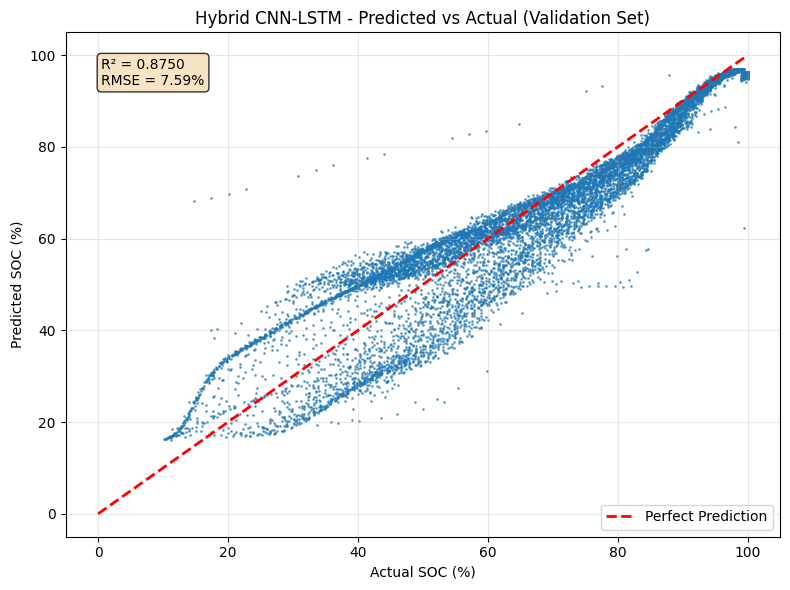

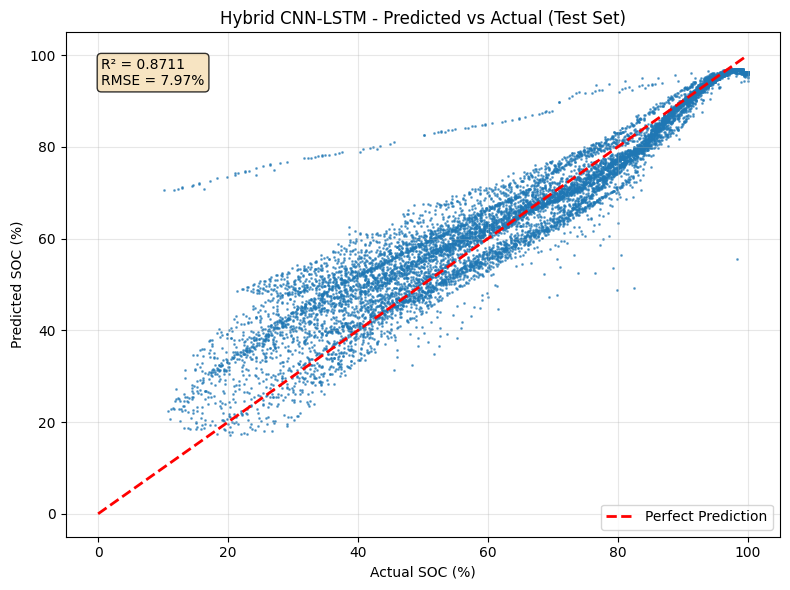

In [9]:
# Visualize predictions on validation set
plot_predictions(y_val, hybrid_val_pred, "Hybrid CNN-LSTM", "(Validation Set)")

# Visualize predictions on test set
plot_predictions(y_test, hybrid_test_pred, "Hybrid CNN-LSTM", "(Test Set)")

## Residual Analysis

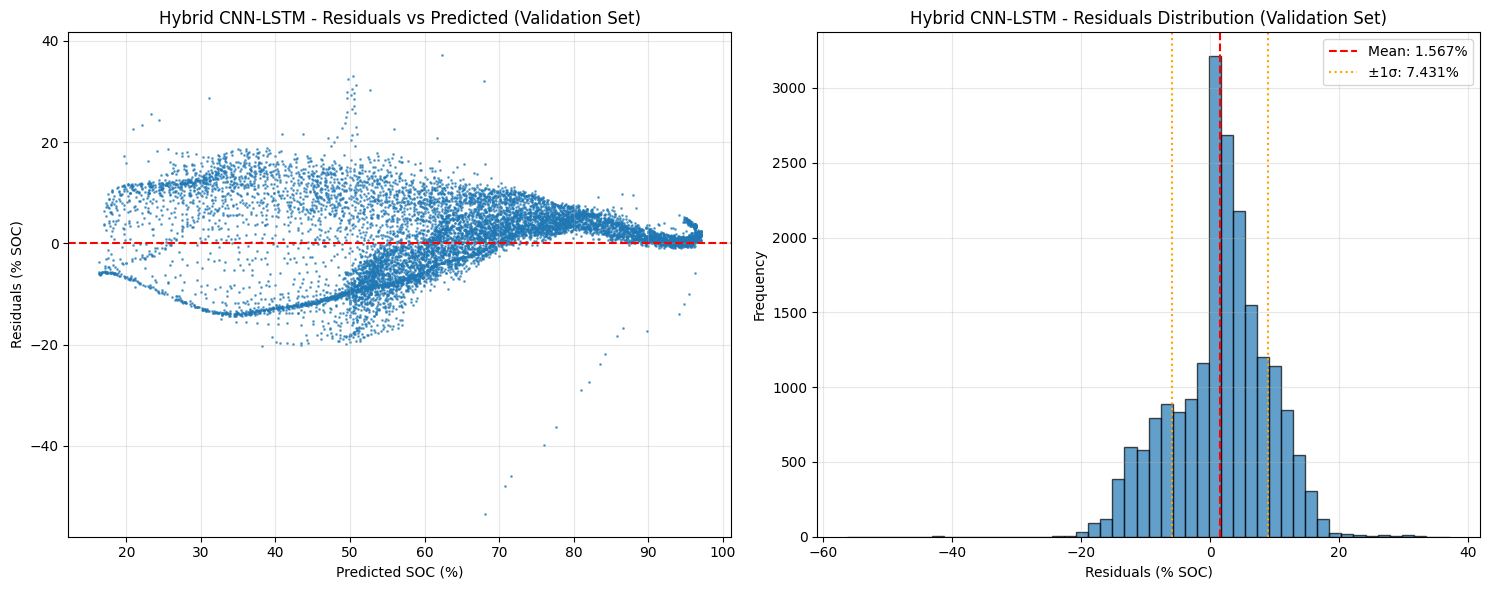

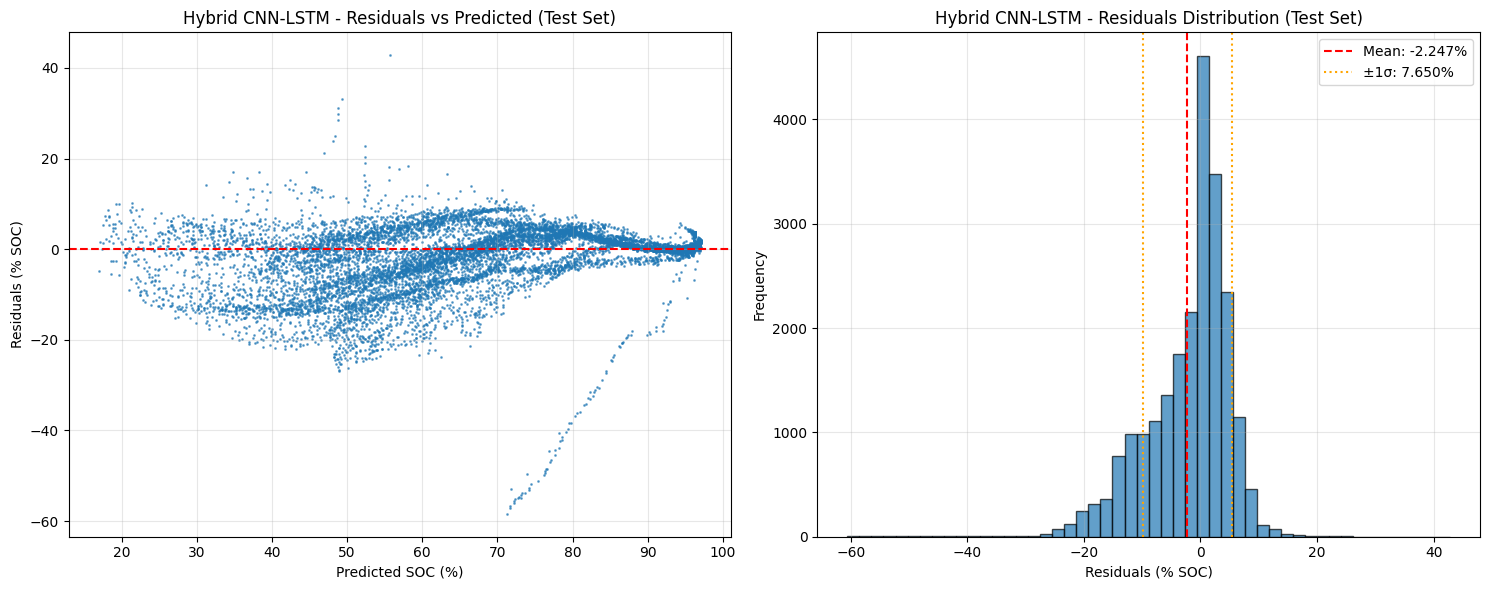

In [10]:
def plot_residuals(y_true, y_pred, model_name, dataset_name=''):
    """Plot residuals to check for patterns."""
    residuals = (y_true - y_pred) * 100  # Convert to percentage
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Sample for visualization if too many points
    if len(y_true) > 10000:
        sample_idx = np.random.choice(len(y_true), 10000, replace=False)
        y_pred_sample = y_pred[sample_idx]
        residuals_sample = residuals[sample_idx]
    else:
        y_pred_sample = y_pred
        residuals_sample = residuals
    
    # Residuals vs Predicted
    axes[0].scatter(y_pred_sample * 100, residuals_sample, alpha=0.6, s=1)
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_xlabel('Predicted SOC (%)')
    axes[0].set_ylabel('Residuals (% SOC)')
    axes[0].set_title(f'{model_name} - Residuals vs Predicted {dataset_name}')
    axes[0].grid(True, alpha=0.3)
    
    # Residuals histogram
    axes[1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Residuals (% SOC)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{model_name} - Residuals Distribution {dataset_name}')
    axes[1].grid(True, alpha=0.3)
    
    # Add statistics
    mean_res = np.mean(residuals)
    std_res = np.std(residuals)
    axes[1].axvline(x=mean_res, color='red', linestyle='--', label=f'Mean: {mean_res:.3f}%')
    axes[1].axvline(x=mean_res + std_res, color='orange', linestyle=':', label=f'±1σ: {std_res:.3f}%')
    axes[1].axvline(x=mean_res - std_res, color='orange', linestyle=':')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Plot residuals for validation and test sets
plot_residuals(y_val, hybrid_val_pred, "Hybrid CNN-LSTM", "(Validation Set)")
plot_residuals(y_test, hybrid_test_pred, "Hybrid CNN-LSTM", "(Test Set)")

MODEL PERFORMANCE COMPARISON

Using 24 features with 60 timesteps

Model                  Train R²     Val R²    Test R²   Test RMSE (%)
---------------------------------------------------------------------------
Linear Regression             -          -   0.208879          19.756
Random Forest                 -          -   0.917825           6.367
XGBoost                       -          -   0.904824           6.852
1D CNN                        -          -   0.798880           9.958
LSTM                          -          -   0.330670          18.170
Hybrid CNN-LSTM        0.917406   0.875002   0.871083           7.973


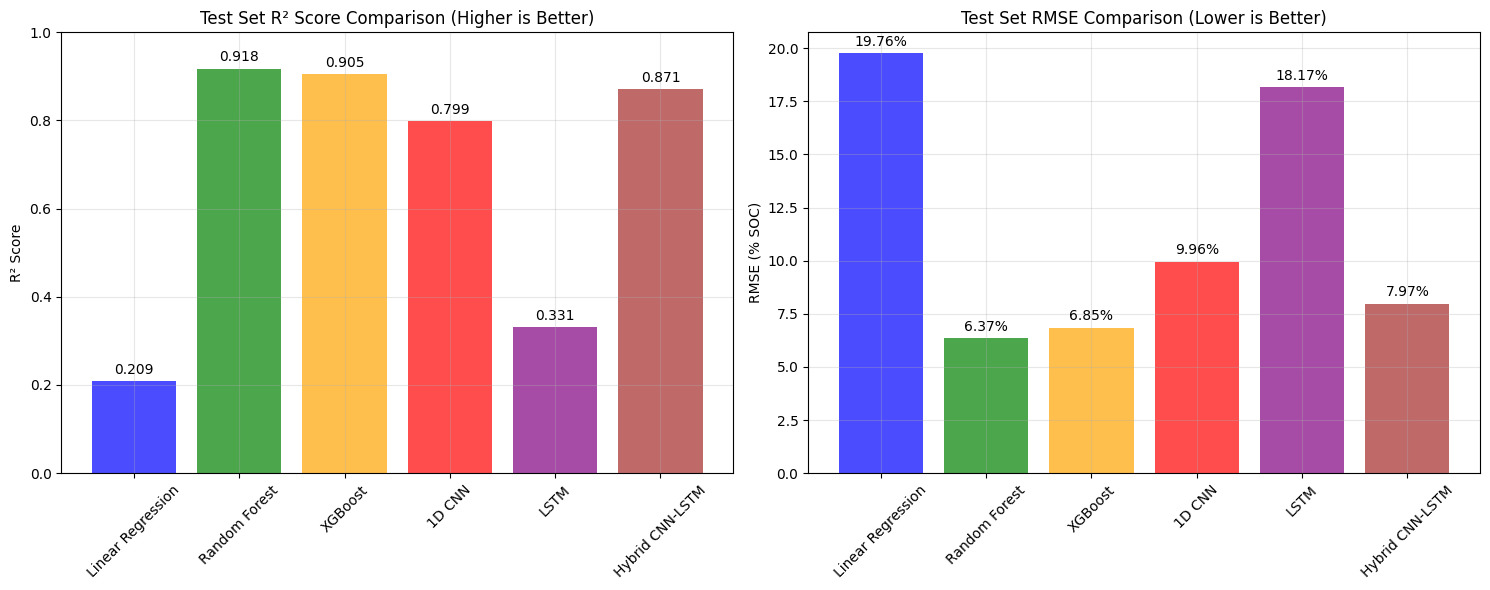

In [11]:
# Load results from previous models if available
baseline_results = {
    'Linear Regression': {'Test_R2': 0.208879, 'Test_RMSE_%': 19.756},
    'Random Forest': {'Test_R2': 0.917825, 'Test_RMSE_%': 6.367},
    'XGBoost': {'Test_R2': 0.904824, 'Test_RMSE_%': 6.852}
}

# Try to load CNN and LSTM results from saved files
try:
    with open(OUTPUT_DIR / '1d_cnn_results.pkl', 'rb') as f:
        cnn_results = pickle.load(f)
        baseline_results['1D CNN'] = {
            'Test_R2': cnn_results['metrics']['test']['r2'],
            'Test_RMSE_%': cnn_results['metrics']['test']['rmse_percent']
        }
except:
    # Use default values if file not found
    baseline_results['1D CNN'] = {'Test_R2': 0.798880, 'Test_RMSE_%': 9.958}

try:
    with open(OUTPUT_DIR / 'lstm_results.pkl', 'rb') as f:
        lstm_results = pickle.load(f)
        baseline_results['LSTM'] = {
            'Test_R2': lstm_results['metrics']['test']['r2'],
            'Test_RMSE_%': lstm_results['metrics']['test']['rmse_percent']
        }
except:
    # Use default values if file not found
    baseline_results['LSTM'] = {'Test_R2': 0.330670, 'Test_RMSE_%': 18.170}

# Add Hybrid CNN-LSTM results
hybrid_results = {
    'Hybrid CNN-LSTM': {
        'Training_R2': hybrid_train_metrics['r2'],
        'Training_RMSE_%': hybrid_train_metrics['rmse_percent'],
        'Validation_R2': hybrid_val_metrics['r2'],
        'Validation_RMSE_%': hybrid_val_metrics['rmse_percent'],
        'Test_R2': hybrid_test_metrics['r2'],
        'Test_RMSE_%': hybrid_test_metrics['rmse_percent']
    }
}

print("="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(f"\nUsing {n_features} features with {sequence_length} timesteps\n")
print(f"{'Model':<20} {'Train R²':>10} {'Val R²':>10} {'Test R²':>10} {'Test RMSE (%)':>15}")
print("-"*75)

# Print baseline results
for model_name, metrics in baseline_results.items():
    print(f"{model_name:<20} {'-':>10} {'-':>10} {metrics['Test_R2']:>10.6f} {metrics['Test_RMSE_%']:>15.3f}")

# Print Hybrid CNN-LSTM results
for model_name, metrics in hybrid_results.items():
    print(f"{model_name:<20} {metrics['Training_R2']:>10.6f} {metrics['Validation_R2']:>10.6f} "
          f"{metrics['Test_R2']:>10.6f} {metrics['Test_RMSE_%']:>15.3f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# R² comparison
models = list(baseline_results.keys()) + list(hybrid_results.keys())
test_r2 = [baseline_results[m]['Test_R2'] for m in baseline_results.keys()] + \
          [hybrid_results[m]['Test_R2'] for m in hybrid_results.keys()]
colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown']

axes[0].bar(models, test_r2, color=colors, alpha=0.7)
axes[0].set_ylabel('R² Score')
axes[0].set_title('Test Set R² Score Comparison (Higher is Better)')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)
for i, (model, score) in enumerate(zip(models, test_r2)):
    axes[0].text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom')

# RMSE comparison
test_rmse = [baseline_results[m]['Test_RMSE_%'] for m in baseline_results.keys()] + \
            [hybrid_results[m]['Test_RMSE_%'] for m in hybrid_results.keys()]

axes[1].bar(models, test_rmse, color=colors, alpha=0.7)
axes[1].set_ylabel('RMSE (% SOC)')
axes[1].set_title('Test Set RMSE Comparison (Lower is Better)')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)
for i, (model, rmse) in enumerate(zip(models, test_rmse)):
    axes[1].text(i, rmse + 0.2, f'{rmse:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [12]:
print("="*80)
print("HYBRID CNN-LSTM MODEL TRAINING SUMMARY")
print("="*80)

print("\nDataset Configuration:")
print(f"   Total features available: {X_train_full.shape[2]}")
print(f"   Features used: {n_features}")
print(f"   Sequence length: {sequence_length} timesteps")
print(f"   Training sequences: {X_train.shape[0]:,}")
print(f"   Validation sequences: {X_val.shape[0]:,}")
print(f"   Test sequences: {X_test.shape[0]:,}")

print("\nModel Architecture:")
print(f"   Total parameters: {total_params:,}")
print(f"   Conv1D layers: 2 (32, 64 filters)")
print(f"   LSTM layers: 2 (64, 32 units)")
print(f"   Dense layers: 2 (32, 16 units)")
print(f"   Dropout rate: 0.3")
print(f"   Recurrent dropout: 0.15")

print("\nTraining Results:")
print(f"   Epochs trained: {len(history.history['loss'])}")
print(f"   Training time: {training_time/60:.2f} minutes")
print(f"   Best validation loss: {np.min(history.history['val_loss']):.6f}")

print("\nPerformance Summary:")
print(f"   Training R²: {hybrid_train_metrics['r2']:.6f}")
print(f"   Validation R²: {hybrid_val_metrics['r2']:.6f}")
print(f"   Test R²: {hybrid_test_metrics['r2']:.6f}")
print(f"   Test RMSE: {hybrid_test_metrics['rmse_percent']:.3f}% SOC")
print(f"   Test MAE: {hybrid_test_metrics['mae_percent']:.3f}% SOC")

# Check for overfitting
train_val_gap = hybrid_train_metrics['r2'] - hybrid_val_metrics['r2']
status = "✅ Good" if train_val_gap < 0.05 else "⚠️ Mild" if train_val_gap < 0.1 else "❌ Severe"
print(f"\nOverfitting Analysis:")
print(f"   Train-Val R² gap: {train_val_gap:.4f} ({status})")
print(f"   Train-Test R² gap: {hybrid_train_metrics['r2'] - hybrid_test_metrics['r2']:.4f}")

# Compare with best baseline
best_baseline = 'Random Forest'
best_baseline_r2 = baseline_results[best_baseline]['Test_R2']
best_baseline_rmse = baseline_results[best_baseline]['Test_RMSE_%']

print(f"\nComparison with Best Baseline ({best_baseline}):")
print(f"   Baseline Test R²: {best_baseline_r2:.6f}")
print(f"   Hybrid CNN-LSTM Test R²: {hybrid_test_metrics['r2']:.6f}")
print(f"   R² Difference: {hybrid_test_metrics['r2'] - best_baseline_r2:+.6f}")
print(f"   Baseline Test RMSE: {best_baseline_rmse:.3f}% SOC")
print(f"   Hybrid CNN-LSTM Test RMSE: {hybrid_test_metrics['rmse_percent']:.3f}% SOC")
print(f"   RMSE Difference: {hybrid_test_metrics['rmse_percent'] - best_baseline_rmse:+.3f}% SOC")

# Compare with individual deep learning models
if '1D CNN' in baseline_results:
    cnn_r2 = baseline_results['1D CNN']['Test_R2']
    cnn_rmse = baseline_results['1D CNN']['Test_RMSE_%']
    
    print(f"\nComparison with 1D CNN:")
    print(f"   CNN Test R²: {cnn_r2:.6f}")
    print(f"   Hybrid Test R²: {hybrid_test_metrics['r2']:.6f}")
    print(f"   R² Improvement: {hybrid_test_metrics['r2'] - cnn_r2:+.6f}")
    print(f"   RMSE Improvement: {cnn_rmse - hybrid_test_metrics['rmse_percent']:+.3f}% SOC")

if 'LSTM' in baseline_results:
    lstm_r2 = baseline_results['LSTM']['Test_R2']
    lstm_rmse = baseline_results['LSTM']['Test_RMSE_%']
    
    print(f"\nComparison with LSTM:")
    print(f"   LSTM Test R²: {lstm_r2:.6f}")
    print(f"   Hybrid Test R²: {hybrid_test_metrics['r2']:.6f}")
    print(f"   R² Improvement: {hybrid_test_metrics['r2'] - lstm_r2:+.6f}")
    print(f"   RMSE Improvement: {lstm_rmse - hybrid_test_metrics['rmse_percent']:+.3f}% SOC")

# Final assessment
print("\n" + "="*80)
if hybrid_test_metrics['r2'] > best_baseline_r2:
    print("✅ The Hybrid CNN-LSTM model outperforms all baseline models!")
elif hybrid_test_metrics['r2'] > max(baseline_results.get('1D CNN', {}).get('Test_R2', 0), 
                                      baseline_results.get('LSTM', {}).get('Test_R2', 0)):
    print("✅ The Hybrid CNN-LSTM model outperforms individual deep learning models!")
else:
    print("The Hybrid CNN-LSTM model provides competitive performance.")
print("="*80)

HYBRID CNN-LSTM MODEL TRAINING SUMMARY

Dataset Configuration:
   Total features available: 45
   Features used: 24
   Sequence length: 60 timesteps
   Training sequences: 65,297
   Validation sequences: 20,303
   Test sequences: 22,669

Model Architecture:
   Total parameters: 57,889
   Conv1D layers: 2 (32, 64 filters)
   LSTM layers: 2 (64, 32 units)
   Dense layers: 2 (32, 16 units)
   Dropout rate: 0.3
   Recurrent dropout: 0.15

Training Results:
   Epochs trained: 51
   Training time: 6.66 minutes
   Best validation loss: 0.008226

Performance Summary:
   Training R²: 0.917406
   Validation R²: 0.875002
   Test R²: 0.871083
   Test RMSE: 7.973% SOC
   Test MAE: 5.422% SOC

Overfitting Analysis:
   Train-Val R² gap: 0.0424 (✅ Good)
   Train-Test R² gap: 0.0463

Comparison with Best Baseline (Random Forest):
   Baseline Test R²: 0.917825
   Hybrid CNN-LSTM Test R²: 0.871083
   R² Difference: -0.046742
   Baseline Test RMSE: 6.367% SOC
   Hybrid CNN-LSTM Test RMSE: 7.973% SOC
   RM

In [13]:
# Save the model
model_path = OUTPUT_DIR / 'final_hybrid_cnn_lstm_model.keras'
hybrid_model.save(model_path)
print(f"✅ Model saved to {model_path}")

# Save results and metrics
results = {
    'model_type': 'Hybrid CNN-LSTM',
    'sequence_length': sequence_length,
    'n_features': n_features,
    'feature_names': available_realistic,
    'total_parameters': total_params,
    'training_time': training_time,
    'epochs_trained': len(history.history['loss']),
    'metrics': {
        'train': hybrid_train_metrics,
        'val': hybrid_val_metrics,
        'test': hybrid_test_metrics
    },
    'history': history.history,
    'architecture': {
        'cnn_filters': [32, 64],
        'kernel_sizes': [5, 3],
        'lstm_units': [64, 32],
        'dropout_rate': 0.3,
        'l2_reg': 0.01
    }
}

results_path = OUTPUT_DIR / 'hybrid_cnn_lstm_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(results, f)
print(f"✅ Results saved to {results_path}")

print("\n" + "="*80)
print("Hybrid CNN-LSTM model training completed successfully!")
print("="*80)

✅ Model saved to processed_data/final_hybrid_cnn_lstm_model.keras
✅ Results saved to processed_data/hybrid_cnn_lstm_results.pkl

Hybrid CNN-LSTM model training completed successfully!
